# Loading dataset

In [2]:
import pandas as pd
ocular_disease = pd.read_csv('csv_files/full_df.csv')
ocular_disease.head()
import warnings
warnings.filterwarnings('ignore')

# Finding number of images per class

In [4]:
# Load the DataFrame
ocular_disease = pd.read_csv('csv_files/full_df.csv')

# Calculate the number of images for each disease using the 'labels' column
disease_counts = ocular_disease['labels'].value_counts()

# Display the result
print(disease_counts)

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64


In [5]:
# Create a mapping of abbreviations to disease names
disease_mapping = {
    "['N']": 'Normal',
    "['D']": 'Diabetic Retinopathy',
    "['G']": 'Glaucoma',
    "['C']": 'Cataract',
    "['A']": 'Age-related Macular Degeneration',
    "['H']": 'Hypertension',
    "['M']": 'Myopia',
    "['O']": 'Other diseases'
}

num_diseases = len(disease_mapping)

# Ploting a bar plot showing the imbalance in dataset

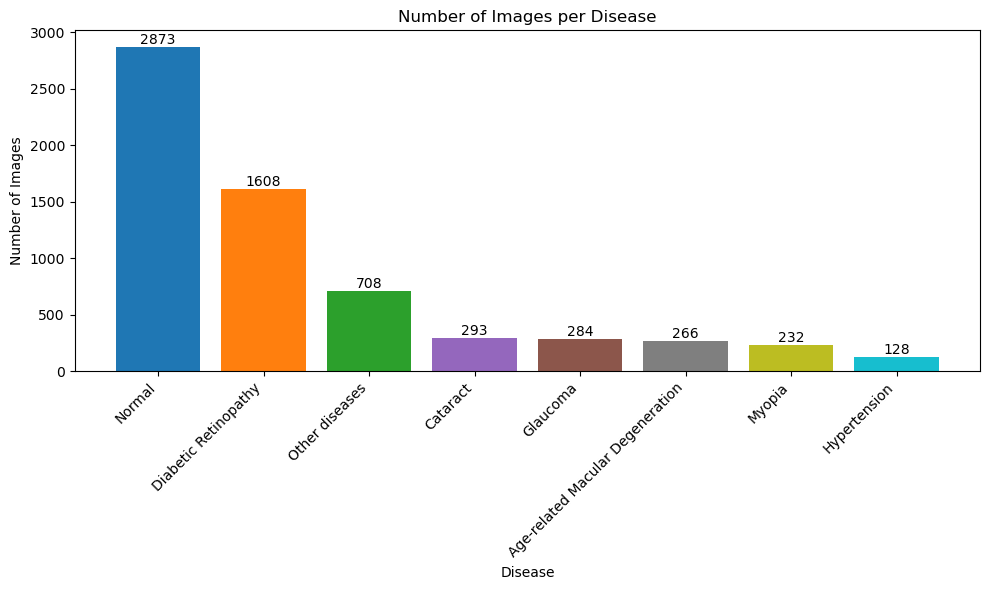

In [6]:
import matplotlib.pyplot as plt

# Calculate the number of images for each disease using the 'labels' column
disease_counts = ocular_disease['labels'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', num_diseases)  # Use a colormap for distinct colors
bars = plt.bar(disease_counts.index, disease_counts.values, color=colors(range(num_diseases)))

# Add labels and title
plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')

# Customize x-axis ticks with disease names
plt.xticks(disease_counts.index, [disease_mapping[d] for d in disease_counts.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Applying preprocessing to images

In [42]:
import os
from torchvision import transforms
from PIL import Image, ImageFilter
import pandas as pd
import numpy as np

# Paths
image_dir = r'D:\RandomProjects\CNN-with-RL\datasets\dataset\ODIR-5K\ODIR-5K\Training Images'
preprocessed_dir = 'datasets/preprocessed'

# Create the preprocessed directory if it doesn't exist
os.makedirs(preprocessed_dir, exist_ok=True)

# Define the image size
IMG_SIZE = 224

def weighted_image(image, alpha=4, beta=-4, gamma=128):
    blurred_image = image.filter(ImageFilter.GaussianBlur(10))

    # Convert to NumPy array
    original_np = np.array(image, dtype=np.float32)
    blurred_np = np.array(blurred_image, dtype=np.float32)

    # Apply weighted transformation in 0-255 scale
    weighted_np = (original_np * alpha) + (blurred_np * beta) + gamma

    # Clip values to ensure they remain valid (0-255)
    weighted_np = np.clip(weighted_np, 0, 255).astype(np.uint8)

    # Convert back to PIL Image
    return Image.fromarray(weighted_np, mode='RGB')  # Ensure RGB mode consistency


# Preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(weighted_image),
    transforms.ToTensor()
])

# Function to preprocess an image
def preprocess_image_pytorch(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img)
        return img_tensor
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to save preprocessed image
def save_preprocessed_image(tensor, save_path):
    try:
        img = transforms.ToPILImage()(tensor).convert('RGB')
        img.save(save_path)
    except Exception as e:
        print(f"Error saving image {save_path}: {e}")

# Loop through dataset and process images
for index, row in ocular_disease.iterrows():
    left_image_filename = row['Left-Fundus']
    right_image_filename = row['Right-Fundus']

    left_image_path = os.path.join(image_dir, left_image_filename)
    right_image_path = os.path.join(image_dir, right_image_filename)

    if os.path.exists(left_image_path):
        left_image_tensor = preprocess_image_pytorch(left_image_path)
        if left_image_tensor is not None:
            left_save_path = os.path.join(preprocessed_dir, left_image_filename)
            save_preprocessed_image(left_image_tensor, left_save_path)

    if os.path.exists(right_image_path):
        right_image_tensor = preprocess_image_pytorch(right_image_path)
        if right_image_tensor is not None:
            right_save_path = os.path.join(preprocessed_dir, right_image_filename)
            save_preprocessed_image(right_image_tensor, right_save_path)


# Calculating number of images that needs to be generated per class

In [43]:
# Calculate the number of images needed for each disease to reach the maximum count of 1000
max_images_per_class = 1000
images_needed = max_images_per_class - disease_counts
images_needed = images_needed[images_needed > 0]  # Only keep diseases that need more images

# Display the result
print("Number of images needed for each disease class to balance the dataset:")
print(images_needed)

Number of images needed for each disease class to balance the dataset:
labels
['O']    292
['C']    707
['G']    716
['A']    734
['M']    768
['H']    872
Name: count, dtype: int64


# Total number of images needed

In [44]:
images_needed.sum()

4089

# Generating imgaes and saving their info in a new csv file

In [48]:
import numpy as np
import imgaug.augmenters as iaa
import os
from PIL import Image
import pandas as pd

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(1.0),  # Flip horizontally
    iaa.Flipud(1.0),  # Flip vertically
    iaa.Rot90(1),     # Rotate 90 degrees
    iaa.Rot90(2),     # Rotate 180 degrees
    iaa.Rot90(3),     # Rotate -90 degrees
])

# Create the augmented directory if it doesn't exist
augmented_dir = 'datasets/augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

image_dir = 'datasets/preprocessed'

# Function to augment and save images
def augment_and_save_image(image_path, save_path, augmenter):
    try:
        img = Image.open(image_path)
        img_np = np.array(img)
        img_aug = augmenter(image=img_np)
        img_aug_pil = Image.fromarray(img_aug)
        img_aug_pil.save(save_path)
    except FileNotFoundError:
        print(f"Image file not found: {image_path}")
    except Exception as e:
        print(f"Error augmenting image {image_path}: {e}")

# List to store information of augmented images
augmented_data = []

# Loop through the DataFrame and augment images as needed
for label, num_needed in images_needed.items():
    if num_needed > 0:  # Only augment if images are needed
        label_rows = ocular_disease[ocular_disease['labels'] == label]
        count = 0
        
        for i in range(int(num_needed)):
            count += 1
            random_image_index = np.random.choice(label_rows.index)
            row = label_rows.loc[random_image_index]

            image_filename = row['filename']
            image_path = os.path.join(image_dir, image_filename)
            absolute_image_path = os.path.abspath(image_path)

            new_filename = f"augmented_{label[2]}_{i}_{image_filename}"
            new_filepath = os.path.join(augmented_dir, new_filename)

            augment_and_save_image(absolute_image_path, new_filepath, seq)

            # Store information of the augmented image
            new_row = row.copy()
            new_row['filename'] = new_filename
            new_row['filepath'] = new_filepath
            new_row['labels'] = label
            augmented_data.append(new_row)

        print(label, count)

# Convert the list to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Save the DataFrame to a new CSV file
augmented_df.to_csv("csv_files/augmented_images_info.csv", index=False)

['O'] 292
['C'] 707
['G'] 716
['A'] 734
['M'] 768
['H'] 872


# Plotting a bar plot showing images generated per class

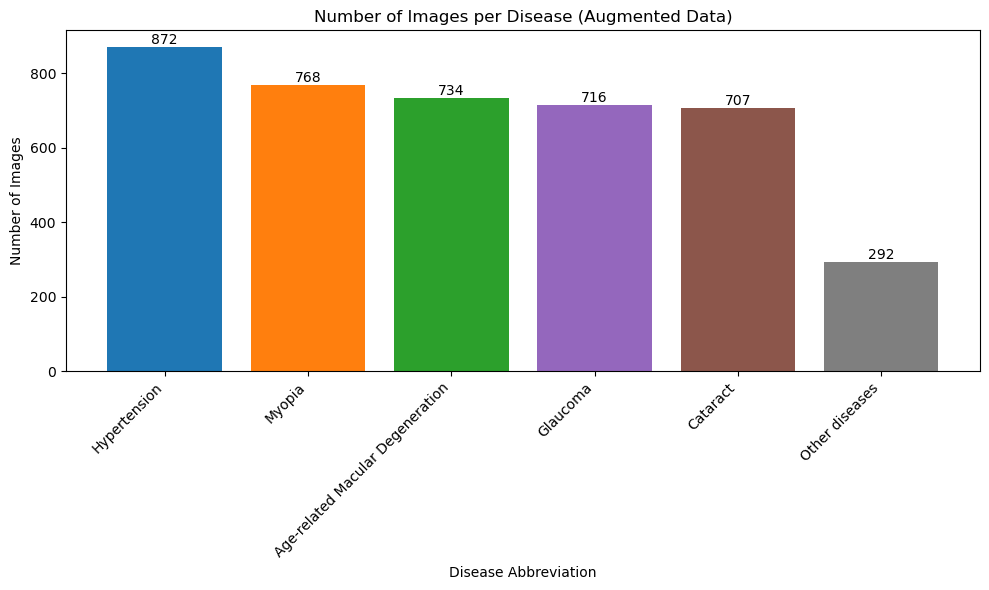

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
augmented_df = pd.read_csv('csv_files/augmented_images_info.csv')

# Calculate disease counts for augmented images
aug_disease_counts = augmented_df['labels'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', num_diseases)  # Use a colormap for distinct colors
bars = plt.bar(aug_disease_counts.index, aug_disease_counts.values, color=colors(range(num_diseases)))

# Add labels and title
plt.xlabel('Disease Abbreviation')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease (Augmented Data)')

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')

# Customize x-axis ticks with disease names
plt.xticks(aug_disease_counts.index, [disease_mapping[d] for d in aug_disease_counts.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [50]:
aug_disease_counts.sum()

4089

# Merging newly generated images with original images

In [51]:
import os
import shutil
import pandas as pd

# Define the directories
preprocessed_dir = 'datasets/preprocessed'
augmented_dir = 'datasets/augmented_images'
merged_dir = 'datasets/merged_images'

# Create the merged directory if it doesn't exist
os.makedirs(merged_dir, exist_ok=True)

# Load the dataframes
full_df = pd.read_csv('csv_files/full_df.csv')
augmented_df = pd.read_csv('csv_files/augmented_images_info.csv')

# Concatenate the dataframes
merged_df = pd.concat([full_df, augmented_df], ignore_index=True)

# Update the filepath column
merged_df['filepath'] = merged_df.apply(
    lambda row: os.path.join(preprocessed_dir, row['filename']) if os.path.exists(os.path.join(preprocessed_dir, row['filename'])) else os.path.join(augmented_dir, row['filename']),
    axis=1
)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('csv_files/balanced_full_df.csv', index=False)

# Copy images to the merged directory
for index, row in merged_df.iterrows():
    shutil.copy(row['filepath'], merged_dir)

print("Merging completed. The merged images are in the 'merged_images' folder and the balanced CSV file is 'balanced_full_df.csv'.")

Merging completed. The merged images are in the 'merged_images' folder and the balanced CSV file is 'balanced_full_df.csv'.


# Plotting a bar plot showing the class distribution in the final dataset

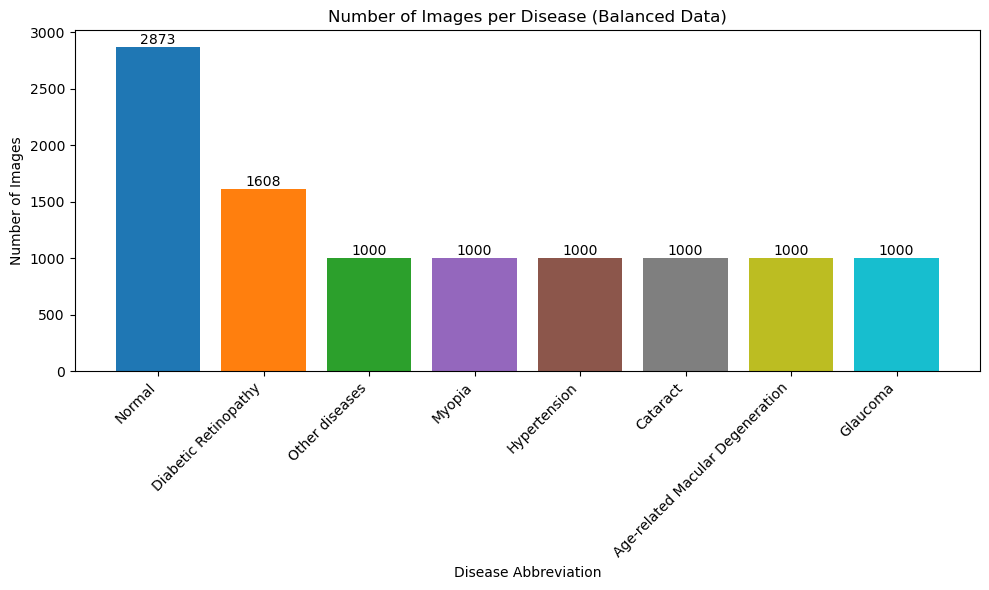

In [52]:
import pandas as pd

import matplotlib.pyplot as plt

# Load the DataFrame
balanced_df = pd.read_csv('csv_files/balanced_full_df.csv')

# Calculate disease counts
disease_counts = balanced_df['labels'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab10', len(disease_counts))  # Use a colormap for distinct colors
bars = plt.bar(disease_counts.index, disease_counts.values, color=colors(range(len(disease_counts))))

# Add labels and title
plt.xlabel('Disease Abbreviation')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease (Balanced Data)')

# Add counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, yval, ha='center', va='bottom')

# Customize x-axis ticks with disease names
plt.xticks(disease_counts.index, [disease_mapping[d] for d in disease_counts.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Splitting images into train, val and test

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

# Load the DataFrame
df = pd.read_csv('csv_files/balanced_full_df.csv')

# Separate original and augmented images
original_df = df[~df['filename'].str.contains('augmented')]
augmented_df = df[df['filename'].str.contains('augmented')]

# Split the original images
train_original_df, temp_original_df = train_test_split(original_df, test_size=0.3, stratify=original_df['labels'], random_state=42)
val_original_df, test_original_df = train_test_split(temp_original_df, test_size=0.5, stratify=temp_original_df['labels'], random_state=42)

# Split the augmented images
train_augmented_df, temp_augmented_df = train_test_split(augmented_df, test_size=0.3, stratify=augmented_df['labels'], random_state=42)
val_augmented_df, test_augmented_df = train_test_split(temp_augmented_df, test_size=0.5, stratify=temp_augmented_df['labels'], random_state=42)

# Combine the splits to maintain the ratio
train_df = pd.concat([train_original_df, train_augmented_df])
val_df = pd.concat([val_original_df, val_augmented_df])
test_df = pd.concat([test_original_df, test_augmented_df])

# Create directories for train, val, and test datasets
os.makedirs('datasets/train_images', exist_ok=True)
os.makedirs('datasets/val_images', exist_ok=True)
os.makedirs('datasets/test_images', exist_ok=True)

# Function to copy images to respective directories
def copy_images(df, folder_name):
    for index, row in df.iterrows():
        filename = row['filename']
        label = row['labels'][2:-2]  # Extract label from the format "['X']"
        label_dir = os.path.join(folder_name, label)
        os.makedirs(label_dir, exist_ok=True)
        src_path = os.path.join('merged_images', filename)
        dst_path = os.path.join(label_dir, filename)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)

# Copy images to respective directories
copy_images(train_df, 'datasets/train_images')
copy_images(val_df, 'datasets/val_images')
copy_images(test_df, 'datasets/test_images')

# Save the DataFrames to CSV files
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)

print("Data split completed. Train, validation, and test images are in their respective folders.")

Data split completed. Train, validation, and test images are in their respective folders.


# Loading images

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the transformation to convert PIL images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the datasets
train_dataset = ImageFolder(root='datasets/train_images', transform=transform)
val_dataset = ImageFolder(root='datasets/val_images', transform=transform)
test_dataset = ImageFolder(root='datasets/test_images', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print the number of images in each dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 7336
Number of validation images: 1572
Number of test images: 1573
